# Numerical Methods for PDEs

## Quick setup — imports and plotting defaults
Run this cell first. SciPy is optional for most of this notebook.

In [3]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
import time
plt.rcParams.update({'figure.figsize': (7,4), 'image.cmap': 'viridis'})


# Elliptic PDEs

**What they model:** steady-state distributions — electrostatic potential in charge-free regions, or steady temperature in a plate.

**Key idea:** No time dependence. The solution is determined by boundary conditions alone.

**Laplace equation:**

$$ \nabla^2 V(x,y) = 0. $$

or, in 2D:

$$ \frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} = 0. $$


To solve this equation use the *finite difference method*.

Let's reobtain the second partial derivative using Taylor expansions. At $\mathcal{O}(\Delta x^3)$

$$
f(x_i+\Delta x) \approx f(x_i) + f'(x_i)\,\Delta x 
+ \tfrac{1}{2} f''(x_i)(\Delta x)^2 
+ \tfrac{1}{6} f^{(3)}(x_i)(\Delta x)^3 
$$

and

$$
f(x_i-\Delta x) \approx f(x_i) - f'(x_i)\,\Delta x 
+ \tfrac{1}{2} f''(x_i)(\Delta x)^2 
- \tfrac{1}{6} f^{(3)}(x_i)(\Delta x)^3 
$$

If we add both expansions, the odd terms cancel out:
$$
f(x_i+\Delta x) + f(x_i-\Delta x) 
\approx 2 f(x_i) + f''(x_i)(\Delta x)^2 
$$

Rearranging to isolate $f''(x_i)$
$$
 f''(x_i)(\Delta x)^2 \approx f(x_i+\Delta x) - 2 f(x_i) + f(x_i-\Delta x) 
$$

or

$$
 f''(x_i) \approx \frac{f(x_i+\Delta x) - 2 f(x_i) + f(x_i-\Delta x)}{(\Delta x)^2} 
$$


Then, we've got:

\begin{equation}
f''(x_i) \approx \frac{f(x_i+\Delta x) - 2 f(x_i) + f(x_i-\Delta x)}{(\Delta x)^2},
\end{equation}

\begin{equation}
f''(y_i) \approx \frac{f(y_i+\Delta y) - 2 f(y_i) + f(y_i-\Delta y)}{(\Delta y)^2}.
\end{equation}



Taking $\Delta x = \Delta y = h$, Laplace equation becomes

\begin{equation}
\frac{V(x_i+h,y_j) + V(x_i-h,y_j) + V(x_i,y_j+h) + V(x_i,y_j-h) - 4V(x_i,y_j)}{h^2} = 0.
\end{equation}

To apply the finite difference method, we assume that the region in which we want to compute 
the potential $V$ is divided into a grid with spacing $h$ (see figure). 
The intersections of the grid lines are called nodes.

<table><tr><td align="center">
  <img src="./img/pdes_fig1.jpg" alt="fig1" width="500">
</td></tr></table>

For certain nodes, the potential value is known due to the initial and boundary conditions (fixed nodes), 
while for the remaining nodes (free nodes) the potential is calculated using the expression obtained 
by isolating $V(x_i,y_j)$ from above:

\begin{equation}
V(x_i,y_j) = \frac{1}{4}\left[ V(x_i+h,y_j) + V(x_i-h,y_j) + V(x_i,y_j+h) + V(x_i,y_j-h) \right].
\end{equation}

This expression can be generalized as

\begin{equation}
V_{i,j} = \frac{1}{4}\left( V_{i+1,j} + V_{i-1,j} + V_{i,j+1} + V_{i,j-1} \right).
\end{equation}


**Discrete intuition:** The value at an interior node is the average of its four nearest neighbors (the 5-point figure). This suggests an iterative idea: repeatedly replace each interior node by that average — the values 'relax' toward the true harmonic function.


- Initially, assign fixed nodes the values imposed by the initial and boundary conditions, 
and the free nodes the value zero.
- Keeping the potential at fixed nodes unchanged, 
we compute the potential at each free node using the equations above.
- The potential obtained after the first iteration will only be approximate. 
The calculation is repeated at each free node using the new values until the desired accuracy is reached.


Below we implement a small, clear demonstration

## Worked examples 

### Jacobi relaxation

<table><tr><td align="center">
  <img src="./img/pdes_fig2.png" alt="fig1" width="250">
</td></tr></table>

**Example A:** Implement one Jacobi update step on a 5×5 grid where the top row is 1 and other boundaries are 0. Print the grid before and after one step.



In [4]:

# Implementing the small Jacobi example and warm-ups
def single_jacobi_step(V):
    Vn = V.copy()
    Vn[1:-1,1:-1] = 0.25*(V[1:-1,2:]+V[1:-1,:-2]+V[2:,1:-1]+V[:-2,1:-1])
    return Vn


# Example A
V = np.zeros((5,5))
V[-1,:] = 1.0  # top row = 1
print('Initial 5x5 grid:')
print(V)
V1 = single_jacobi_step(V)
print('\nAfter one Jacobi iteration:')
print(np.round(V1,4))

Initial 5x5 grid:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]]

After one Jacobi iteration:
[[0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.25 0.25 0.25 0.  ]
 [1.   1.   1.   1.   1.  ]]


**Example B (for you to do):** Run 50 Jacobi iterations and plot the result. Show the maximum change in values after 50 iterations. Run an example where you setup a tolerance for the loop to stop.

### In-place Gauss–Seidel
Gauss–Seidel uses the newest updated values immediately; this often halves the number of iterations compared to Jacobi. Below is a simple implementation, comparing Gauss–Seidel with Jacobi results and iteration counts to reach a tolerance.

In [5]:
# small demo comparing Jacobi and GS for 200x200 grid
## bc = boundary_conditions
def make_bc(n=20, top=1.0):
    V = np.zeros((n,n))
    bc_mask = np.zeros_like(V, dtype=bool); bc_vals = np.zeros_like(V)
    V[-1,:] = top; bc_mask[-1,:] = True; bc_vals[-1,:] = top
    V[0,:] = 0; V[:,0] = 0; V[:,-1] = 0
    bc_mask[0,:] = True; bc_mask[:,0] = True; bc_mask[:,-1] = True
    return V, bc_mask, bc_vals


def single_jacobi_step_loop(V):
    Vn = V.copy()
    ny, nx = Vn.shape
    for i in range(1, ny-1):
        for j in range(1, nx-1):
           Vn[i,j] = 0.25*(V[i+1,j] + V[i-1,j] + V[i,j+1] + V[i,j-1])
    return Vn

## Gauss Seidel implementation
def gauss_seidel_step(V, bc_mask, bc_vals):
    ## note the V.copy() step is gone
    ny, nx = V.shape
    for i in range(1, ny-1):
        for j in range(1, nx-1):
            ## only do calculation if mask not applied
            if not bc_mask[i,j]: V[i,j] = 0.25*(V[i+1,j] + V[i-1,j] + V[i,j+1] + V[i,j-1])
    V[bc_mask] = bc_vals[bc_mask]
    return V





In [6]:
def gauss_seidel_step_rb(V, bc_mask, bc_vals):
    # red update: (i+j) even
    V[1:-1:2,1:-1:2] = 0.25*(
        V[:-2:2,1:-1:2] + V[2::2,1:-1:2] +
        V[1:-1:2,:-2:2] + V[1:-1:2,2::2]
    )
    V[2:-1:2,2:-1:2] = 0.25*(
        V[1:-2:2,2:-1:2] + V[3::2,2:-1:2] +
        V[2:-1:2,1:-2:2] + V[2:-1:2,3::2]
    )

    # black update: (i+j) odd
    V[2:-1:2,1:-1:2] = 0.25*(
        V[1:-2:2,1:-1:2] + V[3::2,1:-1:2] +
        V[2:-1:2,:-2:2] + V[2:-1:2,2::2]
    )
    V[1:-1:2,2:-1:2] = 0.25*(
        V[:-2:2,2:-1:2] + V[2::2,2:-1:2] +
        V[1:-1:2,1:-2:2] + V[1:-1:2,3::2]
    )

    V[bc_mask] = bc_vals[bc_mask]
    return V


V20, bc_mask20, bc_vals20 = make_bc(200, top=1.0)


In [7]:
# Run Jacobi
Vj = V20.copy(); t0 = time.time()
for _ in range(2000):
    Vj = single_jacobi_step(Vj)
Vj_time = time.time()-t0

# Run Jacobi loop
Vj1 = V20.copy(); t0 = time.time()
for _ in range(2000):
    Vj1 = single_jacobi_step_loop(Vj1)
Vj1_time = time.time()-t0

# Run GS
Vg = V20.copy(); t0 = time.time()
for _ in range(2000):
    Vg = gauss_seidel_step(Vg, bc_mask20, bc_vals20)
Vg_time = time.time()-t0

# Run GS RB
Vgrb = V20.copy(); t0 = time.time()
for _ in range(2000):
    Vgrb = gauss_seidel_step_rb(Vgrb, bc_mask20, bc_vals20)
Vgrb_time = time.time()-t0


Jacobi 2000 steps time: 0.226s, Jacobi rb loops 2000 steps time: 57.948s
GS rb 2000 steps time: 0.346s, GS 2000 steps time: 65.310s


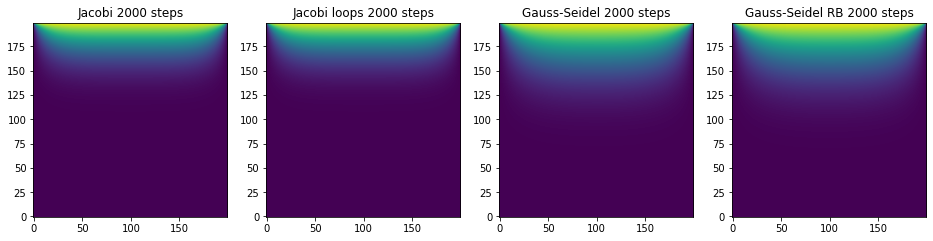

In [8]:

fig, axs = plt.subplots(1, 4, figsize=(16,4))
print(f'Jacobi 2000 steps time: {Vj_time:.3f}s, Jacobi rb loops 2000 steps time: {Vj1_time:.3f}s')
print(f'GS rb 2000 steps time: {Vgrb_time:.3f}s, GS 2000 steps time: {Vg_time:.3f}s')
axs[0].imshow(Vj, origin='lower'); axs[0].set_title('Jacobi 2000 steps')
axs[1].imshow(Vj1, origin='lower'); axs[1].set_title('Jacobi loops 2000 steps')
axs[2].imshow(Vg, origin='lower'); axs[2].set_title('Gauss-Seidel 2000 steps')
axs[3].imshow(Vgrb, origin='lower'); axs[3].set_title('Gauss-Seidel RB 2000 steps'); plt.show()


**Example C (for you to do):** Convergence \& Grid Refinement.
We will perform a refinement study using Laplace's equation on the unit square with these boundary conditions:

$$
V(x,0) = 0, \quad V(x,1) = \sin(\pi x), \quad V(0,y) = 0, \quad V(1,y) = 0.
$$

This problem has the exact solution: $V(x,y) = \frac{\sin(\pi x)\,\sinh(\pi y)}{\sinh(\pi)}$.


Solve the problem numerically using the *Gauss–Seidel* method on grids of size $10\times 10$, $20\times 20$, $40\times 40$, $80\times 80$  and $120\times 120$.  Compare each numerical solution to the analytic one by interpolating both to the same mesh and computing the maximum error. Plot the maximum error versus grid size.

## Exercises (1)

**Exercise 1.** Compute the electrostatic potential inside a square domain (charge-free) whose top side is a conductor at 100 V and the other three sides are grounded (0 V). Use a 40×40 grid. Compare Jacobi and Gauss–Seidel convergence. Include equipotential contour plots.

<table><tr><td align="center">
  <img src="./img/pdes_fig2.png" alt="fig1" width="200">
</td></tr></table>

**Exercise 2.** Same square, but two thin conducting wires inside are held at +100 V and -100 V. Borders grounded. Use 40×40 mesh. Plot potentials.

<table><tr><td align="center">
  <img src="./img/pdes_fig3.png" alt="fig1" width="250">
</td></tr></table>



**Exercise 3.** A square of side 100 cm is surrounded by conducting wires connected to ground.  
The charge inside the square is zero except for two shaded regions (see figure) 
that carry charge densities of $+1 \,\mathrm{C/m^2}$ and $-1 \,\mathrm{C/m^2}$, respectively.  
Evaluate how the electrostatic potential is distributed inside the square. First just assume only the negative charge is present, and then, do both.


<table><tr><td align="center">
  <img src="./img/pdes_fig4.png" alt="fig1" width="250">
</td></tr></table>


In this case, due to the presence of charge inside the square, 
we must use Poisson’s equation:

\begin{equation}
\frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} = - \frac{\rho}{\epsilon_0}.
\end{equation}

To solve the problem, we modify the solution we saw to Laplace equation as follows:

\begin{equation}
\frac{V(x_i+h,y_j) + V(x_i-h,y_j) + V(x_i,y_j+h) + V(x_i,y_j-h) - 4V(x_i,y_j)}{h^2} = - \frac{\rho(x,y)}{\epsilon_0}.
\end{equation}

which gives

\begin{equation}
V_{i,j} = \frac{1}{4}\left( V_{i+1,j} + V_{i-1,j} + V_{i,j+1} + V_{i,j-1} \right) + \frac{h^2 \rho_{i,j}}{4 \epsilon_0}.
\end{equation}


**Exercise 4.** We have a square aluminum plate of $40 \times 40$ cm, 
with thermal conductivity coefficient $k = 0.49 \,\mathrm{cal/(s \cdot cm \cdot ^\circ C)}$, 
subjected at its boundaries to the constant temperatures shown in the figure. In the steady state, determine graphically the temperature **and** heat flux distributions in the plate.  
Use a $10 \times 10$ mesh.

<table><tr><td align="center">
  <img src="./img/pdes_fig5.png" alt="fig1" width="250">
</td></tr></table>


In the steady state, with no heat sources or sinks, Laplace’s law holds:

\begin{equation}
\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} = 0,
\end{equation}

which leads to

\begin{equation}
T_{i,j} = \frac{1}{4}\left( T_{i+1,j} + T_{i-1,j} + T_{i,j+1} + T_{i,j-1} \right).
\end{equation}

Once the steady state is reached, Fourier’s law gives the heat fluxes in both axes:

\begin{align}
q_x &= -k \frac{\partial T}{\partial x} \simeq -k \frac{T_{i,j+1} - T_{i,j-1}}{2h}, \\
q_y &= -k \frac{\partial T}{\partial y} \simeq -k \frac{T_{i+1,j} - T_{i-1,j}}{2h}.
\end{align}


# Parabolic PDEs — 1D heat equation

**What they model:** diffusion/heat flow; solutions smooth out in time. 

**Key property:** infinite speed of propagation in the continuous model (but numerically limited by stability).

### FTCS (Forward Time, Centered Space)

Analyze the one-dimensional heat flow as in an insulated metal bar, 
which can exchange heat at both ends.

<table><tr><td align="center">
  <img src="./img/pdes_fig6.jpg" alt="fig1" width="250">
</td></tr></table>

If the bar is oriented along the $x$-axis, the temperature $T(x,t)$ 
at position $x$ and time $t$ satisfies Fourier’s equation:

\begin{equation}
\frac{\partial T(x,t)}{\partial t} = c^2 \frac{\partial^2 T(x,t)}{\partial x^2},
\end{equation}

where
\begin{equation}
c^2 = \frac{K}{c_e \rho},
\end{equation}
with $K$ the thermal conductivity, $c_e$ the specific heat, and $\rho$ the density.



Converting the differential equation into finite difference form, 
at point $(x_i,t_j)$ we get

\begin{equation}
\frac{T(x_i,t_j+\Delta t) - T(x_i,t_j)}{\Delta t} 
= c^2 \frac{T(x_i+\Delta x,t_j) - 2T(x_i,t_j) + T(x_i-\Delta x,t_j)}{(\Delta x)^2}.
\end{equation}

Letting

\begin{equation}
r = \frac{c^2 \Delta t}{(\Delta x)^2},
\end{equation}

we obtain

\begin{equation}
T(x_i,t_j+\Delta t) = T(x_i,t_j) + r\left[ T(x_i+\Delta x,t_j) + T(x_i-\Delta x,t_j) - 2T(x_i,t_j) \right].
\end{equation}



Suppose we want to solve our equation for $0 \leq x \leq a$ and $0 \leq t \leq b$ 
with the initial condition $T(x,0) = f(x)$ for $0 \leq x \leq a$ 
and boundary conditions $T(0,t)=c_1$, $T(a,t)=c_2$ for $0 \leq t \leq b$.  

<table><tr><td align="center">
  <img src="./img/pdes_fig7.jpg" alt="fig1" width="250">
</td></tr></table>


Dividing the rectangle $R = \{(x,t): 0 \leq x \leq a, \, 0 \leq t \leq b\}$ 
into a grid with spacing $\Delta x$ and $\Delta t$, 
the equation above can be written more compactly as

\begin{equation}
T_{i,j+1} = T_{i,j} + r\left( T_{i+1,j} + T_{i-1,j} - 2T_{i,j} \right).
\end{equation}

For the differencial equation to provide a stable solution, it is necessary that
$$
0 \leq r \leq \frac{1}{2},
$$

which means

\begin{equation}
\Delta t \leq \frac{(\Delta x)^2}{2 c^2}.
\end{equation}

This is known as **CFL (Courant–Friedrichs–Lewy)** stability condition




### Show where CLF condition comes from:

#### 1) Start from the FTCS update

For the 1-D heat equation the FTCS update is

$T_i^{\,n+1} = T_i^{\,n} + r\big(T_{i+1}^{\,n} - 2T_i^{\,n} + T_{i-1}^{\,n}\big), \qquad r=\alpha \frac{\Delta t}{\Delta x^2}.$

(for simplicity: $T_i^n \equiv T_{i,j}$.)


#### 2) Insert a single Fourier (harmonic) mode

We assume a solution component of the form

$T_i^n = \xi^n e^{i k x_i}, \qquad x_i = i\Delta x,$

where $k$ is a wavenumber and $\xi$ is the *mode amplitude per time step*. The factor $\xi$ is the *amplification factor* for one time step (often denoted $G$). Plugging into the scheme:

Left side:

$T_i^{\,n+1} = \xi^{\,n+1} e^{i k x_i}.$

Right side (use $x_{i\pm1}=x_i \pm \Delta x$):

$T_i^n + r\big(T_{i+1}^n -2T_i^n + T_{i-1}^n\big) = \xi^n e^{i k x_i}\Big[\,1 + r\big(e^{i k \Delta x}+e^{-i k \Delta x}-2\big)\Big].$

Divide both sides by $\xi^n e^{i k x_i}$ to get the amplification factor $G$:

$G \equiv \frac{\xi^{\,n+1}}{\xi^n} = 1 + r\big(e^{i k \Delta x}+e^{-i k \Delta x}-2\big).$


#### 3) Simplify using trig identities

Use $e^{i\theta}+e^{-i\theta}=2\cos\theta$:

$G = 1 + r\big(2\cos(k\Delta x) - 2\big) = 1 - 2r\big(1 - \cos(k\Delta x)\big).$

Use the identity $1-\cos\theta = 2\sin^2(\theta/2)$:

$\;\; G = 1 - 4r\,\sin^2\!\big(\tfrac{k\Delta x}{2}\big).$

So $G$ is **real** and depends on $k\Delta x$ through $\sin^2$.

#### 4) Stability requirement

A Fourier mode is stable under the time-stepping iff its amplitude does not grow:

$|G| \le 1 \quad \text{for every admissible }k.$

From the expression for $G$ we note:

* $\sin^2(\tfrac{k\Delta x}{2})$ ranges between $0$ and $1$.
* Therefore $G$ ranges between  
  $G_{\max} = 1$ (when $\sin^2=0$),  
  $G_{\min} = 1 - 4r$ (when $\sin^2=1$).

So the interval of possible $G$ values is $[\,1-4r,\; 1\,]$.

For stability we need the whole interval to lie inside $[-1,1]$.  
The only potentially dangerous end is the minimum $1-4r$. Require

$1-4r \ge -1 \;\;\Longrightarrow\;\; -4r \ge -2 \;\;\Longrightarrow\;\; r \le \tfrac12.$

Also physically we take $r \ge 0$ (positive diffusivity and forward time step), so the stability condition becomes

$\;0 \le r \le \tfrac12.$

#### 5) What happens at equality / when $r>\tfrac12$

* If $r=\tfrac12$, then  

  $G = 1 - 4\cdot\tfrac12\sin^2\theta = 1 - 2\sin^2\theta = \cos(2\theta), \quad\text{with }\theta=\tfrac{k\Delta x}{2}.$  

  So $G=\cos(2\theta)$ and $|G|\le 1$ for all modes — marginal stability (no amplification, but some modes can oscillate in sign).

* If $r>\tfrac12$, then $1-4r < -1$. That means there exist wavenumbers (those with $\sin^2=1$) for which $|G|>1$.  
  Those Fourier components **grow exponentially** in time and the numerical solution blows up (diverges).


## Crank-Nicolson

Crank–Nicolson is an **implicit, second–order accurate** method that averages the explicit (FTCS) and fully implicit schemes.  
It is **unconditionally stable**, requiring a tridiagonal solve each step but yielding higher accuracy without a CFL restriction.
It works as trapezoidal rule in time (average between $n$ and $n+1$). For interior grid point $i$:

$$
\frac{T_i^{n+1}-T_i^n}{\Delta t} = \frac{c^2}{2\Delta x^2}\Big[(T_{i+1}^n - 2T_i^n + T_{i-1}^n) + (T_{i+1}^{n+1} - 2T_i^{n+1} + T_{i-1}^{n+1})\Big].
$$  

## Worked examples 


**Example A:**  Implement the FCTS scheme for heat conduction in a short insulated rod of length \(L=0.5\) m.  
Use a coarse spatial grid ($\Delta x$ relatively large) and a small time step $\Delta t$ to ensure stability.  
 
   - Choose $\Delta t$ such that the stability parameter  
     $$
     r = \frac{c^2 \Delta t}{\Delta x^2} \leq \tfrac{1}{2}.
     $$  
   Start with an initial temperature of 100°C inside the rod, with boundaries kept at 0°C.  
   Plot the temperature profile at several times (e.g., \(t=0\), an intermediate time, and final time).  
   
   - Unstable run. Increase $\Delta t$ so that $r > \tfrac{1}{2}$, repeat the simulation and plot the results. 
   

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def ftcs_demo(L=0.5, nx=11, c2=0.049, dt=0.02, tau=0.2):
    dx = L/(nx-1)
    x = np.linspace(0, L, nx)
    Nt = int(tau/dt) + 1

    # Temperature array: time vs space
    T = np.zeros((Nt, nx))
    T[0, :] = 100.0           # initial condition
    T[:, 0] = 0               # left boundary
    T[:, -1] = 0              # right boundary

    r = c2*dt/(dx*dx)
    print(f'r = {r:.3f}')

    # Time stepping
    for n in range(Nt-1):
        T[n+1, 1:-1] = T[n, 1:-1] + r * (T[n, 2:] + T[n, :-2] - 2*T[n, 1:-1])
    return x, T



r = 0.392


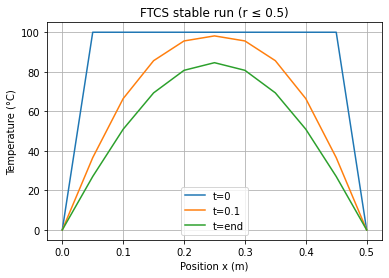

r = 9.800


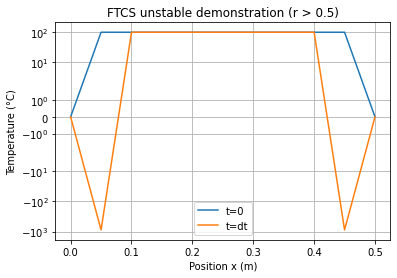

In [10]:
# Stable run
x, Tstable = ftcs_demo(nx=11, dt=0.02, tau=0.2)
plt.figure(figsize=(6,4))
plt.plot(x, Tstable[0, :], label='t=0')
plt.plot(x, Tstable[int(0.1/0.02), :], label='t=0.1')
plt.plot(x, Tstable[-1, :], label='t=end')
plt.xlabel('Position x (m)')
plt.ylabel('Temperature (°C)')
plt.title('FTCS stable run (r ≤ 0.5)')
plt.legend()
plt.grid(True)
plt.show()

# Unstable run
x, Tunstable = ftcs_demo(nx=11, dt=0.5, tau=1.0)  # very large dt -> r >> 1/2
plt.figure(figsize=(6,4))
plt.plot(x, Tunstable[0, :], label='t=0')
plt.plot(x, Tunstable[1, :], label='t=dt')
plt.xlabel('Position x (m)')
plt.ylabel('Temperature (°C)')
plt.title('FTCS unstable demonstration (r > 0.5)')
plt.yscale('symlog')  # symmetric log to show blow-up clearly
plt.legend()
plt.grid(True)
plt.show()


**Example B (for you to do):** Study heat diffusion with a mixed boundary condition.
Consider the same one-dimensional insulated rod, but now the left end of the rod is held at $T=0$ and 
the right end of the rod is insulated, so there is **no heat flow** through it.  
  Mathematically, this means  

  $$
  \frac{\partial T}{\partial x}\bigg|_{x=L} = 0.
  $$
 
Implement the FTCS method for this system. Compare temperature profiles for stable and unstable time steps.  
Observe how the insulated boundary condition affects the shape of the solution compared to the fully fixed case.

Hints:
- For the insulated end, you can use a simple approximation  
  $$
  T_{N} = T_{N-1},
  $$
  which enforces that the temperature at the last grid point is equal to its neighbor (zero slope).
- Test both stable and unstable time steps to confirm the stability condition $r \leq 1/2$.


## Hyperbolic PDEs — wave equation

**What they model:** waves/vibrations; solutions propagate with finite speed.

**Key property:** preserve oscillations and wavefronts; numerical schemes require stability (Courant condition).


We analyze the one-dimensional model of a vibrating string.  
The figure shows the diagram of a vibrating elastic string, oriented along the $x$-axis, with its ends fixed.

<table><tr><td align="center">
  <img src="./img/pdes_fig8.jpg" alt="fig1" width="650">
</td></tr></table>


The displacement of a point $x$ at time $t$, $y(x,t)$, satisfies the wave equation, which in this case can be written as

$$
\frac{\partial^2 y(x,t)}{\partial t^2} = c^2 \frac{\partial^2 y(x,t)}{\partial x^2}
$$

where

$$
c^2 = \frac{\tau}{\rho},
$$

with $\tau$ the string tension and $\rho$ its linear density.

Expressing the wave equation in finite differences, we obtain at point $(x_i,t_j)$:

$$
\frac{y(x_i,t_j+\Delta t) - 2y(x_i,t_j) + y(x_i,t_j-\Delta t)}{(\Delta t)^2}
= c^2 \frac{y(x_i+\Delta x,t_j) - 2y(x_i,t_j) + y(x_i-\Delta x,t_j)}{(\Delta x)^2}
$$

If we introduce the variable $r$ defined by

$$
r = \frac{c \Delta t}{\Delta x}
$$

we arrive at

$$
y(x_i,t_j+\Delta t) = 2y(x_i,t_j) - y(x_i,t_j-\Delta t) + r^2 \left[ y(x_i+\Delta x,t_j) - 2y(x_i,t_j) + y(x_i-\Delta x,t_j) \right]
$$

We want to solve the wave equation for $0 \leq x \leq a$ and $0 \leq t \leq b$ with the following initial and boundary conditions:

$$
y(0,t) = y(a,t) = 0 \quad (0 \leq t \leq b),
$$

$$
y(x,0) = f(x) \quad (0 \leq x \leq a),
$$

$$
\frac{\partial y(x,0)}{\partial t} = g(x) \quad (0 \leq x \leq a).
$$

We divide the rectangle  

$$
R = \{(x,t) : 0 \leq x \leq a, \, 0 \leq t \leq b\}
$$

into a grid with spacing $\Delta x$ and $\Delta t$ as shown in the figure.  

<table><tr><td align="center">
  <img src="./img/pdes_fig9.jpg" alt="fig1" width="500">
</td></tr></table>


The equation can then be written in a more compact form:

$$
y_{i,j+1} = 2y_{i,j} - y_{i,j-1} + r^2 \left( y_{i+1,j} + y_{i-1,j} - 2y_{i,j} \right)
$$



The application of this equation implies that to compute the values at the nodes of row $j+1$, 
we need information from rows $j$ and $j-1$.  
That is, initially, to calculate the values in the third row of nodes, we must know the values in the first and second rows.  

The values in the first row are given by $y(x,0)=f(x)$.  
However, the values of the second row are generally not known, so we use the condition

$$
\frac{\partial y(x,0)}{\partial t} = g(x)
$$

to obtain approximations for these second-row nodes.

Applying the first-order Taylor expansion of $y(x,t)$ around $(x_i,0)$, we find for the second row:

$$
y_{i,1} = f_i + \Delta t \, g_i
$$

If the function $f(x_i)$ is twice differentiable, we can use the second-order Taylor formula to obtain an improved approximation for the second row values:

$$
y_{i,1} = f_i + \Delta t \, g_i + \frac{(\Delta t)^2}{2}\Big( \frac{\partial^2 y}{\partial t^2}(x_i,0) \Big).
$$

and from the PDE:

$$
\frac{\partial^2 y}{\partial t^2} = c^2 \frac{\partial^2 y}{\partial x^2}.
$$

At $t=0$:

$$
\frac{\partial^2 y}{\partial t^2}(x_i,0) = c^2 \frac{\partial^2 f}{\partial x^2}(x_i).
$$

and $\frac{\partial^2 f}{\partial x^2}(x_i) \approx \frac{f_{i+1} - 2f_i + f_{i-1}}{(\Delta x)^2}.$


So:

$$
\frac{\partial^2 y}{\partial t^2}(x_i,0) \approx c^2 \,\frac{f_{i+1} - 2f_i + f_{i-1}}{(\Delta x)^2}.
$$

and 

$$
y_{i,1} = f_i + \Delta t \, g_i + \frac{(\Delta t)^2}{2} \, c^2 \frac{f_{i+1} - 2f_i + f_{i-1}}{(\Delta x)^2}.
$$

Introducing the Courant number ($r = \frac{c \Delta t}{\Delta x}$), then:

$$
y_{i,1} = f_i + \Delta t \, g_i + \frac{r^2}{2}\big(f_{i+1} + f_{i-1} - 2f_i\big).
$$


Finally, for the finite difference equation to provide a stable solution, the calculation process must be stable, which requires. This is called the *Courant stability condition*.

$$
r = \frac{c \Delta t}{\Delta x} \leq 1
$$



## Worked examples 

**Example A**: Consider the 1D wave equation of a vibrating string for $0 \leq x \leq 2$ and $0 \leq t \leq 1$, with wave speed $c = 1.5$ m/s.  
The string is fixed at both ends, so

$$
y(0,t) = y(2,t) = 0 \quad \text{for } 0 \leq t \leq 1.
$$

The initial displacement and velocity are given by:

$$
y(x,0) = f(x) = \sin\left(\frac{\pi x}{2}\right), \quad
\frac{\partial y(x,0)}{\partial t} = g(x) = \sin(\pi x).
$$

Use spatial step $\Delta x = 0.05$ m and time step $\Delta t = 0.02$ s.

Check the Courant stability condition (compute $r = c \, \Delta t / \Delta x$ and verify $r \le 1$). Initialize the solution using the Taylor expansion for the second row. Compute the solution up to $t = 1$ and plot $y(x,t)$ at times $t=0, 0.25, 0.5, 0.75, 1.0$.
Repeat the experiment with a larger time step so that the stability condition is violated (for example increase $\Delta t$ until $r > 1$). Plot the same snapshots and compare with the stable case.



In [11]:
# Wave equation finite-difference: stable vs unstable comparison
import numpy as np
import matplotlib.pyplot as plt

def run_wave(L, dx, dt, c, t_final, f_func, g_func):
    """
    Explicit finite-difference solver for 1D wave eq:
      y_tt = c^2 y_xx
    Returns dict of snapshots at requested times and final arrays.
    """
    r = c * dt / dx
    Nx = int(round(L / dx))
    nodes = Nx + 1
    x = np.linspace(0, L, nodes)
    nt = int(round(t_final / dt))
    # initial conditions
    f = f_func(x)
    g = g_func(x)
    y_prev = f.copy()            # j = 0
    y_curr = np.zeros_like(x)    # j = 1
    # initialize second row (improved, second-order)
    ## this is the crucial line
    for i in range(1, nodes-1):
        y_curr[i] = f[i] + dt * g[i] + 0.5 * (r**2) * (f[i+1] + f[i-1] - 2*f[i])
    y_curr[0] = 0.0
    y_curr[-1] = 0.0
    ##
    
    # snapshots at these times (seconds)
    snapshot_times = [0.0, 0.25, 0.5, 0.75, 1.0]
    snapshot_steps = [int(round(t / dt)) for t in snapshot_times]

    snapshots = {0.0: y_prev.copy()}
    # time marching
    for j in range(1, nt+1):
        y_next = np.zeros_like(x)
        for i in range(1, nodes-1):
            y_next[i] = 2*y_curr[i] - y_prev[i] + (r**2) * (y_curr[i+1] + y_curr[i-1] - 2*y_curr[i])
        y_next[0] = 0.0
        y_next[-1] = 0.0
        # advance
        y_prev, y_curr = y_curr, y_next
        if j in snapshot_steps:
            snapshots[round(j*dt, 6)] = y_curr.copy()
    return {
        "x": x,
        "snapshots": snapshots,
        "r": r,
        "dt": dt,
        "dx": dx,
        "t_final": t_final
    }


Stable run: dx= 0.05 dt= 0.02 r= 0.6
Unstable run: dx= 0.05 dt= 0.05 r= 1.5000000000000002


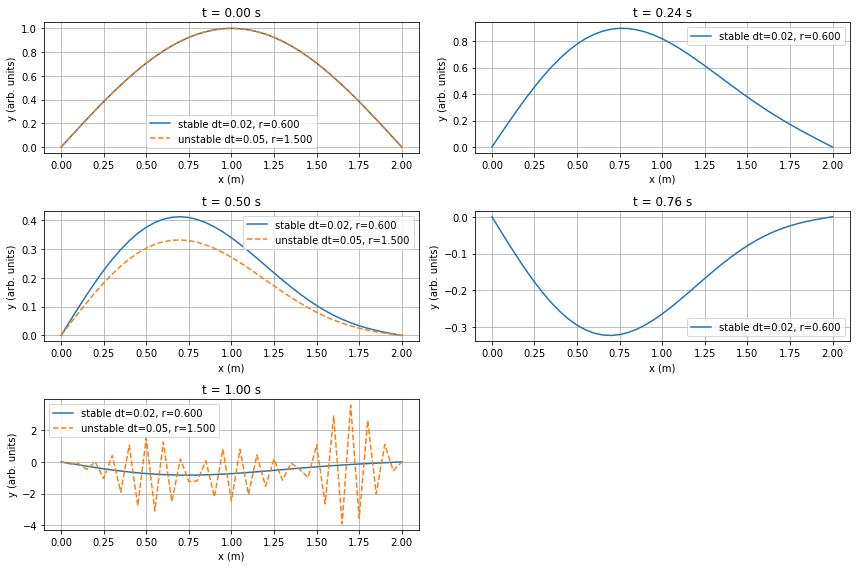

In [12]:
# Problem definition
L = 2.0
dx = 0.05
dt_stable = 0.02    # stable run
dt_unstable = 0.05  # intentionally unstable (r > 1)
c = 1.5
t_final = 1.0

## define the functions that appear as boundary conditions
f_func = lambda x: np.sin(np.pi * x / 2)
g_func = lambda x: np.sin(np.pi * x)

# Run stable
result_stable = run_wave(L, dx, dt_stable, c, t_final, f_func, g_func)
print("Stable run: dx=", dx, "dt=", dt_stable, "r=", result_stable["r"])

# Run unstable
result_unstable = run_wave(L, dx, dt_unstable, c, t_final, f_func, g_func)
print("Unstable run: dx=", dx, "dt=", dt_unstable, "r=", result_unstable["r"])

# Plotting: stable vs unstable snapshots side-by-side
times = sorted(result_stable["snapshots"].keys())  # should be [0,0.25,0.5,0.75,1.0]
x = result_stable["x"]

plt.figure(figsize=(12, 8))
for k, t in enumerate(times):
    plt.subplot(3, 2, k+1)
    y_s = result_stable["snapshots"].get(t)
    y_u = result_unstable["snapshots"].get(t)
    # stable
    if y_s is not None:
        plt.plot(x, y_s, label=f"stable dt={dt_stable}, r={result_stable['r']:.3f}")
    # unstable (may blow up or be noisy)
    if y_u is not None:
        plt.plot(x, y_u, '--', label=f"unstable dt={dt_unstable}, r={result_unstable['r']:.3f}")
    plt.title(f"t = {t:.2f} s")
    plt.xlabel("x (m)")
    plt.ylabel("y (arb. units)")
    plt.grid(True)
    plt.legend()
# tidy layout
plt.tight_layout()
plt.show()

**Example B (for you to do):** Solve the 1D wave equation on the domain $0 \le x \le 1$, $0 \le t \le 0.5$, with $c=1.0$ m/s and fixed ends

$$
y(0,t) = y(1,t) = 0 \quad\text{for } 0\le t\le 0.5.
$$

Initial conditions:

- Localized displacement (Gaussian "pluck") centered at $x_0=0.5$:
  $$
  y(x,0) = f(x) = \exp\!\Big( -\frac{(x-x_0)^2}{2\sigma^2}\Big),
  $$
  with $\sigma = 0.05$.

- Small initial velocity:
  $$
  \frac{\partial y(x,0)}{\partial t} = g(x) = 0.2\sin(\pi x).
  $$

Use $\Delta x = 0.01$ and $\Delta t = 0.005$.

Compute the Courant number $r = c\,\Delta t / \Delta x$ and verify stability. Initialize the solution (use the second-order Taylor formula to set the $j=1$ row). March the solution to $t=0.5$ and plot snapshots of $y(x,t)$ at $t=0, 0.125, 0.25, 0.375, 0.5$. Try a larger $\Delta t$ (e.g. $\Delta t=0.01$) and observe what happens.


## Exercises (2)


**Exercise 5.** A steel bar of length $L=0.5$ m is given with the following data:  
$K=0.12 \,\mathrm{cal/(cm \cdot s \cdot ^\circ C)}$, 
$c_e = 0.113 \,\mathrm{cal/(g \cdot ^\circ C)}$, 
$\rho = 7.8 \,\mathrm{g/cm^3}$.  

Compute the temperature distribution $T(x,t)$ for a time $\tau = 1$ hour, 
starting from the initial condition $T(x,0) = 100^\circ$C for $0 \leq x \leq L$, 
and boundary conditions $T(0,t)=T(L,t)=0$ for $0 < t \leq \tau$.  
Use $\Delta x = 5$ cm.

$$
c^2 = \frac{0.12}{0.113 \cdot 7.8} = 0.136 \,\mathrm{cm^2/s} = 0.049 \,\mathrm{m^2/h},
$$

$$
\Delta t \leq \frac{0.052}{2 \cdot 0.049} = 0.0255 \,h \quad \Rightarrow \quad \Delta t = 0.02 \,h.
$$

As an extra, study the potential Crank-Nicolson implementation.

**Exercise 6.** Solve the wave equation of a vibrating string in the range $0 \leq x \leq 1$ and $0 \leq t \leq 0.5$ for which $c = 2$ m/s, with the following conditions:

$$
y(0,t) = 0, \quad y(1,t) = 0 \quad (0 \leq t \leq 0.5),
$$

$$
y(x,0) = f(x) = \sin(\pi x) + \sin(2\pi x) \quad (0 \leq x \leq 1),
$$

$$
\frac{\partial y(x,0)}{\partial t} = g(x) = 0 \quad (0 \leq x \leq 1),
$$

with $x$ in meters, $t$ in seconds, and $y$ in centimeters.

Use $\Delta x = 0.04$ m, $\Delta t = 0.02$ s.

Thus,

$$
r = \frac{c \Delta t}{\Delta x} = \frac{2 \cdot 0.02}{0.04} = 1 \leq 1
$$

The solution obtained should be presented graphically.

**Exercise ++.** Try to demonstrate the *Courant stability condition*.